# Classifying SNe

This notebook identifies SN 1991bg-like SNe and compares the results of photometric and spectroscopic classifications.

#### Table of Contents:
1. <a href='#reading_in_data'>Reading in the Data</a>: Reading in data from both the analysis pipeline and external publications.
1. <a href='#photometric_classification'>Photometric Classification</a>: Subtyping of Photometrically observed targets.
1. <a href='#intrinsic_properties'>Intrinsic Properties</a>: Plots of fitted parameters from the classification proccess.
1. <a href='#host_properties'>Host Galaxy Properties</a>: Identification of trends with host galaxy mass and SSFR.


In [1]:
import sys
import warnings
from multiprocessing import Pool
from pathlib import Path

import numpy as np
import pandas as pd
from astropy.cosmology import WMAP9 as wmap9
from astropy.table import Table
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from sndata.sdss import sako18
from tqdm.notebook import tqdm

sys.path.insert(0, '../')
from phot_class.classification import classify_targets

sako18.download_module_data()

# Output directory for figures
fig_dir = Path('./notebook_figs/classification')
fig_dir.mkdir(exist_ok=True, parents=True)
results_dir = Path('../results/').resolve()

## Reading in the Data <a id='reading_in_data'></a>

To save time later on, we read in all of the necessary data in advance. We start with the photometric classifications from SDSS.


In [2]:
# Read in sdss classifications
sdss_master = sako18.load_table('master')
sako_classification = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'spec_class': sdss_master['Classification']
})
sako_classification.set_index('obj_id', inplace=True)
sako_classification['spec_class'].value_counts()


Variable    3225
Unknown     2009
pSNII       1628
AGN          906
zSNIa        824
pSNIa        624
SNIa         499
zSNII        357
SNII          64
SNIa?         41
zSNIbc        40
pSNIbc        16
SNIc          12
SNIb          10
SLSN           3
Name: spec_class, dtype: int64

Next, we select only object Id's for targets with observations in at least two bands and at least one point before and after max.

In [3]:
non_sne = sako_classification[sako_classification['spec_class'].isin(('Variable', 'AGN'))]


def passes_cut(obj_id):
    """Return if an object has data in >=2 bands and at
    least one point before and after max.
    
    Return is false for all AGN and Variables
    
    Args:
        obj_id (str): The object Id
        
    Returns:
        A boolean
    """

    if obj_id in non_sne.index:
        return False

    obj_data = sako18.get_data_for_id(obj_id).to_pandas()
    obj_data = obj_data[obj_data.flux / obj_data.fluxerr >= 5]
    num_bands = len(obj_data.band.unique())
    salt2_fits = Table.read(results_dir / 'sdss_salt2_fits.ecsv').to_pandas(index='obj_id')

    try:
        salt_fit = salt2_fits.loc[obj_id]
        return all(
            (salt_fit.pre_max, salt_fit.post_max, (num_bands >= 2))
        )

    except KeyError:
        return False


def get_good_ids(cache_file=results_dir / 'good_ids.npy'):
    """Get SDSS object Ids for targets passing observation cuts
    
    Results are cached to file for performance.
    
    Args:
        cache_file (str): Path to cache return to
        
    Returns:
        An array of object Ids
    """

    if Path(cache_file).exists():
        return np.load(cache_file)

    sako_obj_ids = sako18.get_available_ids()
    with Pool() as p:
        is_good_id = list(tqdm(p.imap(passes_cut, sako_obj_ids), total=len(sako_obj_ids)))

    good_obj_ids = np.array(sako_obj_ids)[is_good_id].tolist()
    np.save(cache_file, good_obj_ids)
    return good_obj_ids


In [4]:
len(get_good_ids())

3882

Finally, we read in the photometric fit results and determine the resulting classification coordinates for each object. We include results from SiFTO and from our own pipeline.


In [5]:
def read_pipeline_results(path):
    """Read pipeline fits and determine resulting classifications
    
    Classifications are cached to file for performance.
    
    Args:
        path (Path): Path of the fit results
    
    Returns: 
        - A DataFrame with fit results
        - A DataFrame with classification coordinates
    """

    # Read fit results
    good_obj_ids = get_good_ids()
    phot_fits = Table.read(path)
    phot_fits = phot_fits[np.isin(phot_fits['obj_id'], good_obj_ids)]

    # Determine classification coords
    cache_path = path.with_name(path.name.replace('fits', 'class'))
    if cache_path.exists():
        phot_class = Table.read(cache_path)

    else:
        phot_class = classify_targets(phot_fits)
        phot_class.write(cache_path)

    # Type cast to DataFrames    
    phot_class = phot_class.to_pandas('obj_id')
    phot_fits = phot_fits.to_pandas().set_index(['source', 'obj_id'])

    return phot_fits, phot_class


def read_sifto_file(path):
    """Read a SiFTO output file
    
    Args:
        path (Path): The path to read
        
    Returns:
        A DataFrame with fits results
    """

    col_names = [
        'obj_id', 'RED', 'LC-DATA', 'ST', 'ST-err', 'COL', 'COL-err',
        'BMAG', 'BMAG-err', 'CHI2DOF', 'MJDMAX', 'MJDMAX-err'
    ]

    df = pd.read_table(
        path,
        skiprows=[0],
        names=col_names,
        delim_whitespace=True,
        engine='python',
    )

    df['chisq'] = df['CHI2DOF']
    df['ndof'] = 1

    # Replace IAU names with with SDSS object Id
    master = sako18.load_table('master')
    master = master[~master['IAUName'].mask]
    sn_id_map = dict(zip(master['IAUName'], master['CID']))
    df['obj_id'] = df['obj_id'].str.lstrip('SDSSsn').replace(sn_id_map)

    # Drop any non sne
    good_obj_ids = get_good_ids()
    df = df[df['obj_id'].isin(good_obj_ids)]

    return df.set_index('obj_id')


def read_sifto_results(results):
    """Read SiFTO fits and determine resulting classifications
    
    Args:
        results (Path): Directory of SiFTO fit results
    
    Returns: 
        - A DataFrame with fit results
        - A DataFrame with classification coordinates
    """

    sifto_dir = results / 'sifto'
    bg_blue = read_sifto_file(sifto_dir / 'sdss-91bg-blue' / 'fitinfo.dat')
    bg_red = read_sifto_file(sifto_dir / 'sdss-91bg-red' / 'fitinfo.dat')
    bg_all = read_sifto_file(sifto_dir / 'sdss-91bg' / 'fitinfo.dat')
    sdss_blue = read_sifto_file(sifto_dir / 'sdss-blue' / 'fitinfo.dat')
    sdss_red = read_sifto_file(sifto_dir / 'sdss-red' / 'fitinfo.dat')
    sdss_all = read_sifto_file(sifto_dir / 'sdss' / 'fitinfo.dat')

    classification_coords = pd.DataFrame({
        'x': sdss_blue['CHI2DOF'] - bg_blue['CHI2DOF'],
        'y': sdss_red['CHI2DOF'] - bg_red['CHI2DOF']
    }).dropna()

    # Yes I could use itertools here, but I don't feel like adding an import
    data_frames = (bg_blue, bg_red, bg_all, sdss_blue, sdss_red, sdss_all)
    sources = ('sn91bg', 'sn91bg', 'sn91bg', 'hsiao_x1', 'hsiao_x1', 'hsiao_x1')
    bands = ('blue', 'red', 'all', 'blue', 'red', 'all')
    for df, source, band in zip(data_frames, sources, bands):
        df['source'] = source
        df['band'] = band
        df.set_index('source', inplace=True, append=True)

    fits = pd.concat(data_frames).reorder_levels(['source', 'obj_id'])
    return fits, classification_coords


In [6]:
coll_path = results_dir / 'collective_fits/with_ext/sdss_sako18_simple_fit_fits.ecsv'
coll_fits, coll_class = read_pipeline_results(coll_path)

band_path = results_dir / 'band_fits/with_ext/sdss_sako18_simple_fit_fits.ecsv'
band_fits, band_class = read_pipeline_results(band_path)

sifto_fits, sifto_class = read_sifto_results(results_dir)


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'pre_max' from integer to float
  
/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'post_max' from integer to float
  
/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:5: TableReplaceWarning: converted column 'pre_max' from integer to float
  """
/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:5: TableReplaceWarning: converted column 'post_max' from integer to float
  """


In [7]:
band_fits.head()


message            band  pre_max  \
source   obj_id                                                               
hsiao_x1 10028   Minimization exited successfully.             all     85.0   
         10028   Minimization exited successfully.  sdss_sako18_g4     17.0   
         10028   Minimization exited successfully.  sdss_sako18_i4     17.0   
         10028   Minimization exited successfully.  sdss_sako18_r4     17.0   
         10028   Minimization exited successfully.  sdss_sako18_u4     17.0   

                 post_max          vparams     mwebv         z  amplitude  \
source   obj_id                                                             
hsiao_x1 10028       20.0  t0,amplitude,x1  0.021712  0.064256   0.000219   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000212   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000237   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000223   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000209   

                           t0        x1  ...  mwebv_err  z_err  amplitude_err  \
source   obj_id                          ...                                    
hsiao_x1 10028   2.453694e+06 -0.141844  ...        NaN    NaN   7.311878e-07   
         10028   2.453694e+06 -0.134201  ...        NaN    NaN   8.785449e-07   
         10028   2.453694e+06 -0.109513  ...        NaN    NaN   1.762427e-06   
         10028   2.453694e+06 -0.107367  ...        NaN    NaN   9.081427e-07   
         10028   2.453694e+06 -0.225185  ...        NaN    NaN   3.735375e-06   

                  t0_err    x1_err  c_err   chisq  ndof  b_max  delta_15  
source   obj_id                                                           
hsiao_x1 10028   0.08593  0.006495    NaN  412.58  32.0 -19.16     1.330  
         10028       NaN  0.007464    NaN    9.06   5.0 -19.09     1.312  
         10028       NaN  0.017644    NaN   32.54   5.0 -19.33     1.258  
         10028       NaN  0.011104    NaN   44.56   5.0 -19.20     1.253  
         10028       NaN  0.026010    NaN    2.56   5.0 -19.06     1.544  

[5 rows x 21 columns]

## Photometric Classification <a id='photometric_classification'></a>

#### Section Contents:
1. <a href='#exploration_of_failed_fits'>Exploration of Failed Fits</a>: A preliminary exploration of the data.
1. <a href='#classification'>Classification Coordinates</a>: Classifying photometrically observed targets.
1. <a href='#intrinsic_properties'>Intrinsic Properties</a>: Distributions of fit parameters
1. <a href='#applying_classifications'>Applying Classifications</a>: Seperates targets into normal and 91bg-like groups.

### Exploration of Failed Fits <a id='exploration_of_failed_fits'></a>

We perform a cursory investigation of any fits that have failed to converge. To start, we note the unique error messages raised in the band and collective fit results.

In [8]:
def get_failed_fits(fits_df):
    """Select failed fits from a DataFrame"""

    failed_fits = fits_df.message.str.lower().str.contains('failed')
    return fits_df[failed_fits]


In [9]:
print('Band fit error messages:\n')
print(get_failed_fits(band_fits).message.unique())

print('\nCollective fit error messages:\n')
print(get_failed_fits(coll_fits).message.unique())


Band fit error messages:

['Hesse Failed. Covariance may not be accurate. Covariance not positive definite.'
 'No data points with S/N > 5.0. Initial guessing failed.']

Collective fit error messages:

['Hesse Failed. Covariance may not be accurate. Covariance not positive definite.'
 'No data points with S/N > 5.0. Initial guessing failed.']


The SNR error is not concerning so long as there are an equal number of occurences between the band and collective fits.

In [10]:
snr_err_msg = 'No data points with S/N > 5.0. Initial guessing failed.'
band_snr_indices = band_fits.message == snr_err_msg
collective_snr_indices = coll_fits.message == snr_err_msg
equal_errors = sum(band_snr_indices) == sum(collective_snr_indices)

print('Equal Number of SNR errors:', equal_errors)


Equal Number of SNR errors: True


We drop the SNR errors for now and look at the distribution of the remaining errors across bands and models.

In [11]:
band_fits_goodsnr = band_fits[band_fits.message != snr_err_msg]
collective_fits_goodsnr = coll_fits[coll_fits.message != snr_err_msg]


In [12]:
band_failed_nosnr = get_failed_fits(band_fits_goodsnr)

print('Band by band error distribution\n')
print('By fitted band (set):')
print(band_failed_nosnr.band.str[-2].value_counts())

print('\nNumber of failed fits per source:')
print(band_failed_nosnr.droplevel(1).index.value_counts())

print('\nNumber of failed fits per object (num_failures number_targets):')
print(band_failed_nosnr.index.value_counts().value_counts())


Band by band error distribution

By fitted band (set):
z    17
r    17
u    17
i    15
g    14
l    12
Name: band, dtype: int64

Number of failed fits per source:
hsiao_x1    91
sn91bg       1
Name: source, dtype: int64

Number of failed fits per object (num_failures number_targets):
6     7
1     6
11    2
5     2
10    1
2     1
dtype: int64


### Classification Coordinates <a id='classification'></a>

We plot the classification coordinates to the fitted light curves.

In [13]:
def calc_delta_chisq(fits_df):
    """Calculate the difference in reduced chisq for overall fits

    Args:
        fits_df (DataFrame): Pipeline fit results

    Returns:
        A pandas series
    """

    fits_hsiao = fits_df.loc['hsiao_x1']
    fits_hsiao = fits_hsiao[fits_hsiao.band == 'all']
    fits_sn91bg = fits_df.loc['sn91bg']
    fits_sn91bg = fits_sn91bg[fits_sn91bg.band == 'all']
    return (fits_hsiao.chisq / fits_hsiao.ndof) - (
            fits_sn91bg.chisq / fits_sn91bg.ndof)


def plot_chisq_scatter(fits_df):
    """Plot classification results

    Args:
        fits_df (DataFrame): DataFrame of fit results
    """

    delta_chi = calc_delta_chisq(fits_df)
    chi_lt0 = delta_chi[delta_chi < 0].index
    chi_gt0 = delta_chi[delta_chi > 0].index

    all_fits = fits_df[fits_df.band == 'all']
    chisq_hs = all_fits.loc['hsiao_x1'].chisq / all_fits.loc['hsiao_x1'].ndof
    chisq_bg = all_fits.loc['sn91bg'].chisq / all_fits.loc['sn91bg'].ndof
    chisq = pd.DataFrame(dict(chisq_hs=chisq_hs, chisq_bg=chisq_bg))

    fig, axis = plt.subplots(1, 1, figsize=(7 / 2, 7 / 2))
    labels = (r'$\Delta\chi^2 < 0$', r'$\Delta\chi^2 > 0$')
    for index, label in zip((chi_lt0, chi_gt0), labels):
        plot_data = chisq.reindex(index)
        axis.scatter(plot_data.chisq_hs, plot_data.chisq_bg,
                     s=5, alpha=.2, label=label)

    ylim = axis.get_ylim()
    axis.plot(ylim, ylim, linestyle='--', color='grey')
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_xlabel(r'Reduced Hsiao $\chi^2$')
    axis.set_ylabel(r'Reduced SN91bg $\chi^2$')
    axis.legend(framealpha=1)

    axis.set_xlim(0, 1e3)
    axis.set_ylim(0, 1e3)
    return fig, axis


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


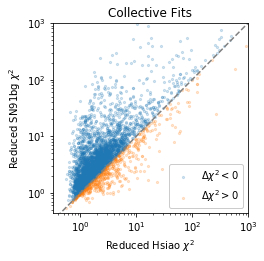

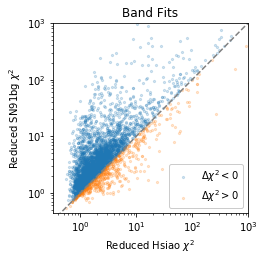

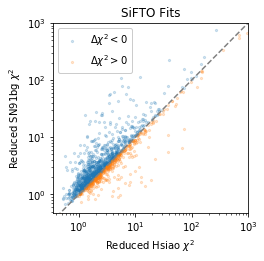

In [14]:
plot_chisq_scatter(coll_fits)
plt.title('Collective Fits')
plt.show()

plot_chisq_scatter(band_fits)
plt.title('Band Fits')
plt.show()

plot_chisq_scatter(sifto_fits)
plt.title('SiFTO Fits')
plt.show()


In [15]:
def get_sako_pec():
    """Get objects flagged as peculiad in Sako+ 2018"""

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sako_data = sako18.load_table('master').to_pandas(index='CID')

    flagged = sako_data.reindex(sako_data.Notes.dropna().index)
    flagged = flagged[flagged.Notes > 1]
    return flagged


def create_border_hist(axis, padding=0, xpos='top', ypos='right'):
    """Create axes for plotting border histograms

    Args:
        axis     (Axis): The matplotlib axis to border
        padding (float): Spacing between the main and bordering axes
        xpos      (str): Put the x histogram on the 'top' or 'bottom'
        ypos      (str): Put the y histogram on the 'left' or 'right'

    Returns:
        - Axis for the upper histogram
        - Axis for the right side histogram
    """

    axis_pos = axis.get_position()
    axis_width = axis_pos.x1 - axis_pos.x0
    axis_height = axis_pos.y1 - axis_pos.y0

    if xpos == 'top':
        histx_pos = axis.get_position()
        histx_pos.y0 += axis_height + padding
        histx_pos.y1 = histx_pos.y1 + .35 * axis_height + padding
        histx = plt.axes(histx_pos)
        histx.set_xlim(axis.get_xlim())
        histx.tick_params(direction='in', labelbottom=False)

    elif xpos == 'bottom':
        histx_pos = axis.get_position()
        histx_pos.y1 -= axis_height + padding
        histx_pos.y0 = histx_pos.y1 - .35 * axis_height - padding
        histx = plt.axes(histx_pos)
        histx.set_xlim(axis.get_xlim())
        histx.tick_params(direction='in', labelbottom=True)

    if ypos == 'right':
        histy_pos = axis.get_position()
        histy_pos.x0 += axis_width + padding
        histy_pos.x1 = histy_pos.x1 + .35 * axis_width + padding
        histy = plt.axes(histy_pos)
        histy.set_ylim(axis.get_ylim())
        histy.tick_params(direction='in', labelleft=False)

    elif ypos == 'left':
        histy_pos = axis.get_position()
        histy_pos.x1 -= axis_width + padding
        histy_pos.x0 = histy_pos.x1 - .35 * axis_width - padding
        histy = plt.axes(histy_pos)
        histy.set_ylim(axis.get_ylim())
        histy.tick_params(direction='in', labelleft=True)

    return histx, histy


def plot_classification(class_df, fits_df, bins=np.arange(-110, 110, 5), padding=0.05):
    """Plot classification results

    Args:
        class_df  (DataFrame): Classification coordinates
        class_df  (DataFrame): Classification results from collective fitting
        fits_df   (DataFrame): DataFrame of fit results
        bins        (ndarray): Bins for the border histograms
        padding       (float): Spacing between the main and bordering axes
    """

    fig, axis = plt.subplots(1, 1, figsize=(7 / 2, 7 / 2))

    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    markers = {2: 's', 3: '^', 4: 'o', 5: 'v'}
    labels = {2: '1991bg', 3: '2000cx', 4: '2002ci', 5: '2002cx'}

    delta_chi = calc_delta_chisq(fits_df)
    chi_lt0 = delta_chi[delta_chi < 0]
    chi_gt0 = delta_chi[delta_chi > 0]

    sako_pec = get_sako_pec()
    all_data_lt = class_df.reindex(chi_lt0.index).drop(sako_pec.index, errors='ignore')
    all_data_gt = class_df.reindex(chi_gt0.index).drop(sako_pec.index, errors='ignore')

    axis.scatter(all_data_lt.x, all_data_lt.y, s=7, alpha=.5)
    axis.scatter(all_data_gt.x, all_data_gt.y, s=7, color='C1', alpha=.5)

    axis.axvline(0, color='grey', linestyle='--')
    axis.axhline(0, color='grey', linestyle='--')
    axis.set_xlabel(x_label, fontsize=10, labelpad=10)
    axis.set_ylabel(y_label, fontsize=10)
    axis.set_xlim(min(bins), max(bins))
    axis.set_ylim(min(bins), max(bins))
    axis.xaxis.set_minor_locator(MultipleLocator(5))
    axis.yaxis.set_minor_locator(MultipleLocator(5))

    for flag_type, flag_data in sako_pec.groupby('Notes'):
        plt_data = class_df.reindex(flag_data.index)
        marker = markers[flag_type]
        label = labels[flag_type]
        axis.scatter(plt_data.x, plt_data.y, s=20,
                     marker=marker, zorder=9,
                     color='k', label=label, facecolor='none')

    histx_bg, histy_norm = create_border_hist(axis, padding)
    histx_norm = histx_bg.twinx()
    histy_bg = histy_norm.twiny()

    histx_norm.hist(all_data_lt.x, bins=bins, color='C0')
    histx_bg.hist(all_data_gt.x, bins=bins, histtype='step', color='C1')

    histy_norm.hist(all_data_lt.y, bins=bins, color='C0', orientation='horizontal')
    histy_bg.hist(all_data_gt.y, bins=bins, histtype='step', color='C1', orientation='horizontal')

    axis.set_xlim(-60, 60)
    axis.set_ylim(-60, 60)
    histx_norm.set_xlim(axis.get_xlim())
    histy_norm.set_ylim(axis.get_ylim())


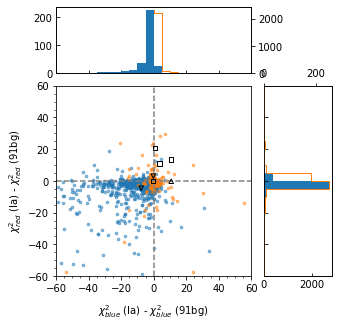

In [16]:
plot_classification(
    class_df=coll_class, 
    fits_df=coll_fits
)

plt.savefig(fig_dir / 'collective_classification.pdf', bbox_inches='tight')
plt.show()


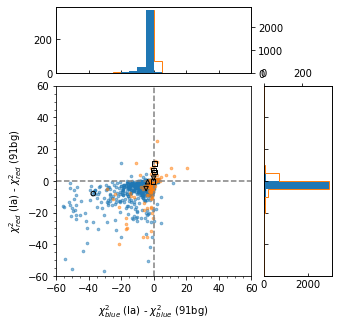

In [17]:
plot_classification(
    class_df=band_class, 
    fits_df=band_fits
)

plt.savefig(fig_dir / 'band_classification.pdf', bbox_inches='tight')
plt.show()


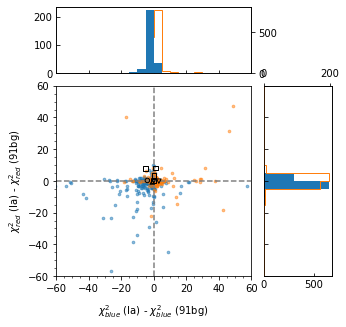

In [18]:
plot_classification(
    class_df=sifto_class, 
    fits_df=sifto_fits
)
    
plt.savefig(fig_dir / 'sifto_classification.pdf', bbox_inches='tight')
plt.show()


In [19]:
def plot_classification_with_subtypes(
        classification_coords,
        bins=np.arange(-110, 110, 5),
        padding=0.02):
    """Plot classification results

    Args:
        classification_coords (DataFrame): Classification coordinates
        bins        (ndarray): Bins for the border histograms
        padding       (float): Spacing between the main and bordering axes
    """

    fig, axes = plt.subplots(2, 2, figsize=(7.5, 7.5), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=.5, hspace=.5)

    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    axes[0, 0].set_ylabel(y_label)
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('')
    axes[1, 0].set_ylabel(y_label)
    axes[1, 0].set_xlabel(x_label)
    axes[1, 1].set_xlabel(x_label)

    categories = [
        {'SNe Ia': ['SNIa', 'SNIa?']},
        {'SNe II': ['pSNII', 'zSNII']},
        {'SNe Ibc': ['SNIc', 'SNIb', 'SNIbc']},
        {'Unknown': 'Unknown'}
    ]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sdss_pd = sako18.load_table('master').to_pandas()
        sdss_pd['obj_id'] = sdss_pd['CID']
        sdss_pd.set_index('obj_id', inplace=True)
        class_with_sdss = classification_coords.join(sdss_pd)

    for axis, category_dict in zip(axes.flatten(), categories):
        histx, histy = create_border_hist(axis, padding)

        axis.set_xlim(-60, 60)
        axis.set_ylim(-60, 60)
        histx.set_xlim(axis.get_xlim())
        histy.set_ylim(axis.get_ylim())

        axis.axvline(0, color='grey', linestyle='--', zorder=0)
        axis.axhline(0, color='grey', linestyle='--', zorder=0)
        for cat_label, cat_list in category_dict.items():
            category_data = class_with_sdss[np.isin(class_with_sdss.Classification, cat_list)]
            axis.scatter(
                x=category_data.x,
                y=category_data.y,
                label=f'{cat_label} ({len(category_data)})',
                alpha=.7,
                s=8)

            histx.hist(category_data.x, bins=bins)
            histy.hist(category_data.y, bins=bins, orientation='horizontal')
            axis.legend(loc='upper left', framealpha=1)

    axis.xaxis.set_minor_locator(MultipleLocator(5))
    axis.yaxis.set_minor_locator(MultipleLocator(5))


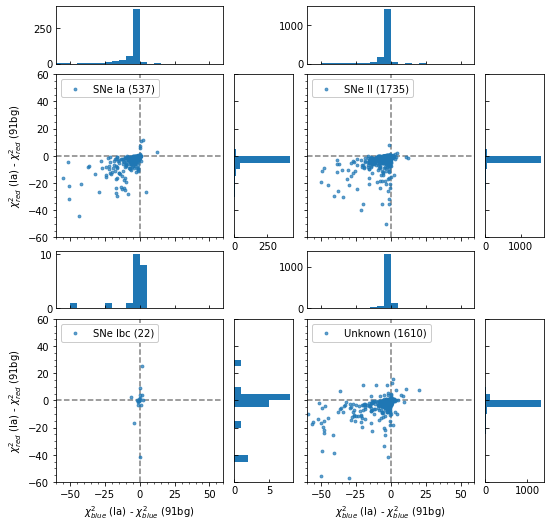

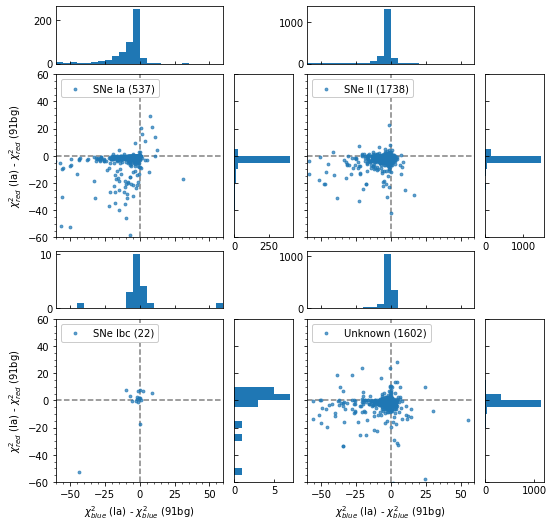

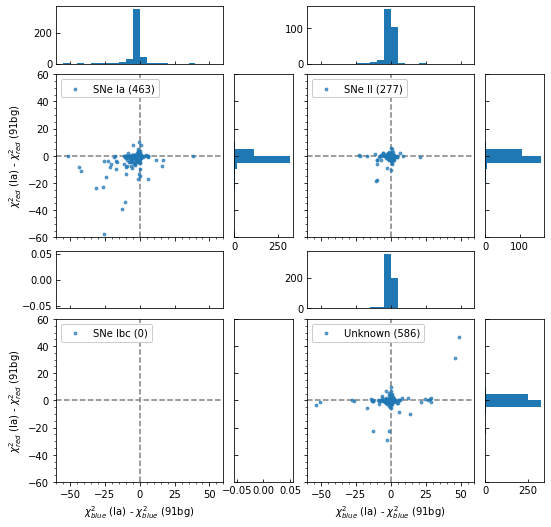

In [20]:
data_iter = (band_class, coll_class, sifto_class)
fnames = ('band', 'coll', 'sifto')
for classification_data, fname in zip(data_iter, fnames):
    plot_classification_with_subtypes(classification_data)
    plt.savefig(fig_dir / f'{fname}_sub_classification.pdf', bbox_inches='tight')
    plt.show()


## Intrinsic Properties <a id='intrinsic_properties'></a>

We consider the distribution of fit parameters.

In [21]:
def plot_param_histogram(fits_df, source, fit_type, param):
    """Plot a histogram of fit parameters
    
    Args:
        fits_df (DataFrame): Fit results
        source        (str): Name of the model to display results for
        fit_type      (str): Use "band" or "collective" fit results
        param         (str): Name of the parameter to plot
    """

    # Select data to plot
    fits_using_source = fits_df.loc[source]
    hist_data = fits_using_source[fits_using_source['band'] == 'all'][param]

    fig, axis = plt.subplots(1, 1, figsize=(7, 7))
    axis.hist(hist_data, bins=20)

    latex_safe_source = source.split("_")[0]
    axis.set_title(param + f' Distribution ({latex_safe_source} - {fit_type} Fits)'.title())
    axis.set_xlabel(param)
    axis.set_ylabel('Combined number of targets')


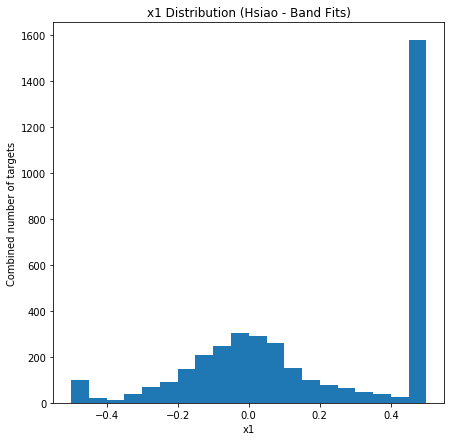

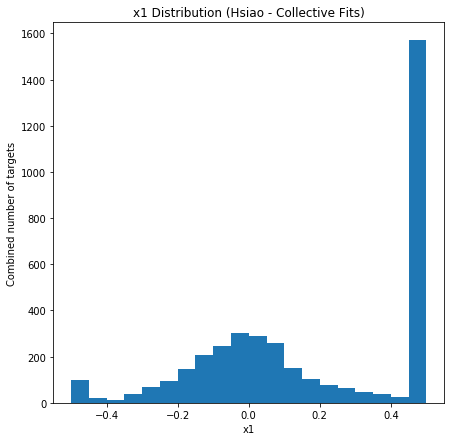

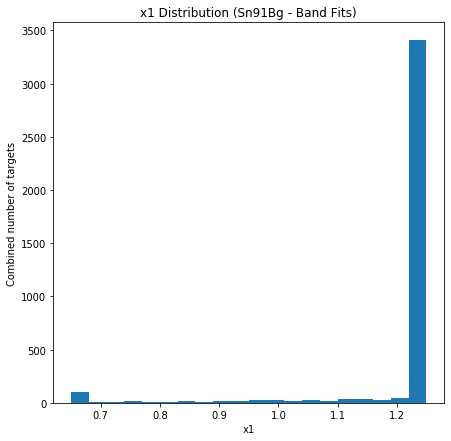

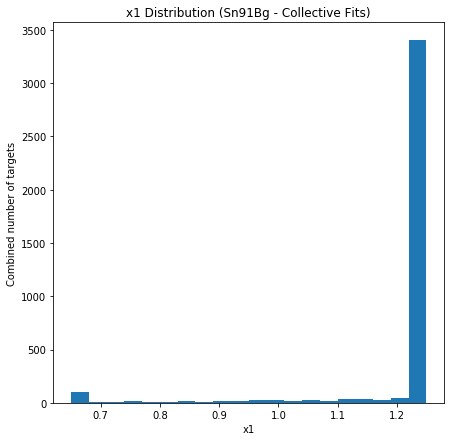

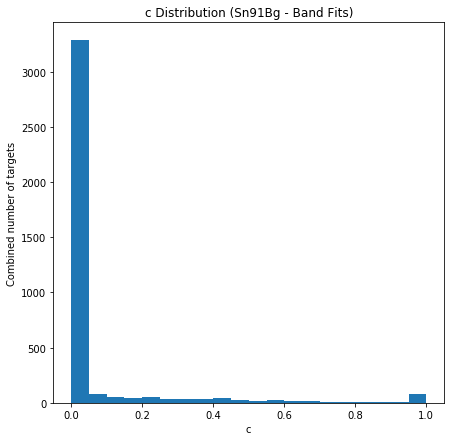

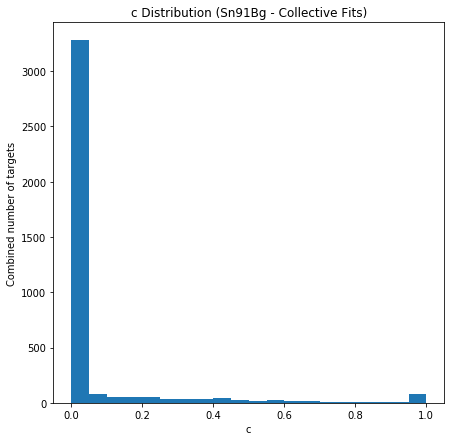

In [22]:
for model_name in ('hsiao_x1', 'sn91bg'):
    for param in ('x1', 'c'):
        if model_name == 'hsiao_x1' and param == 'c':
            continue

        for fit_type, fit_data in zip(('band', 'collective'), (band_fits, coll_fits)):
            plot_param_histogram(fit_data, model_name, fit_type, param)
            plt.show()


### Applying Classifications <a id='applying_classifications'></a>

We seperate targets into normal and 9abg-like groups based on their classification coordinates.

In [23]:
def classify_targets(
        class_coords,
        x_cut=0.25,
        y_cut=0.25,
        categories=('SNIa', 'pSNIa', 'zSNIa', 'SNIa?', 'Unknown')):
    """Classify targets as being normal or 91bg-like
    
    Args:
        class_coords (DataFrame): Dataframe with x and y columns
        x_cut            (float): X cutoff for being 91bg-like
        y_cut            (float): Y cutoff for being 91bg-like
        categories       (tuple): Only include objects with given SDSS classifications
        
    Returns:
        - A collection of normal object Id's
        - A collection of 91bg-like object Id's
    """

    indices = sdss_master['CID'][np.isin(sdss_master['Classification'], categories)]
    in_category = class_coords.reindex(indices)

    bg_like = in_category[(in_category.x >= x_cut) & (in_category.y >= y_cut)]
    normal = in_category[(in_category.x < x_cut) & (in_category.y < y_cut)]
    return normal.index, bg_like.index


In [24]:
coll_ia, coll_bg = classify_targets(coll_class)
band_ia, band_bg = classify_targets(band_class)
sifto_ia, sifto_bg = classify_targets(sifto_class)

print_data = zip(
    ('Collective', 'Band', 'SiFTO'),
    (coll_ia, band_ia, sifto_ia),
    (coll_bg, band_bg, sifto_bg)
)

for source, ia_ids, bg_ids in print_data:
    print(source, 'fitting classifications:')
    print('Ia:', len(ia_ids), 'objects')
    print('bg:', len(bg_ids), 'objects\n')
    

Collective fitting classifications:
Ia: 2943 objects
bg: 40 objects

Band fitting classifications:
Ia: 3387 objects
bg: 23 objects

SiFTO fitting classifications:
Ia: 800 objects
bg: 29 objects



### Host Galaxy Properties <a id='host_properties'></a>

We start with some book keeping and create dataframes for various subsets of the host galaxy data.

In [25]:
host_photometry = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'host_id': sdss_master['objIDHost'],  # Host galaxy object ID in SDSS DR8 Database 
    'ra': sdss_master['RAhost'],  # Right ascension of galaxy host (degrees) 
    'dec': sdss_master['DEChost'],  # Declination of galaxy host (degrees) 
    'dist': sdss_master['separationhost'],  # Distance from SN to host (arcsec) 
    'distnorm': sdss_master['DLRhost'],  # Normalized distance from SN to host (dDLR) 
    'z_KF': sdss_master['zphothost'],  # Host photometric redshift (KF algorithm) 
    'z_KF_err': sdss_master['zphoterrhost'],  # zphothost uncertainty
    'z_RF': sdss_master['zphotRFhost'],  # Host photometric redshift (RF algorithm) 
    'z_RF_err': sdss_master['zphotRFerrhost'],  # zphotRFhost uncertainty 
    'u_mag': sdss_master['dereduhost'],  # Host galaxy u-band magnitude (dereddened) 
    'u_mag_err': sdss_master['erruhost'],  # Host galaxy u-band magnitude uncertainty 
    'g_mag': sdss_master['deredghost'],  # Host galaxy g-band magnitude (dereddened)
    'g_mag_err': sdss_master['errghost'],  # Host galaxy g-band magnitude uncertainty 
    'r_mag': sdss_master['deredrhost'],  # Host galaxy r-band magnitude (dereddened)
    'r_mag_err': sdss_master['errrhost'],  # Host galaxy r-band magnitude uncertainty 
    'i_mag': sdss_master['deredihost'],  # Host galaxy i-band magnitude (dereddened) 
    'i_mag_err': sdss_master['errihost'],  # Host galaxy i-band magnitude uncertainty 
    'z_mag': sdss_master['deredzhost'],  # Host galaxy z-band magnitude (dereddened) 
    'z_mag_err': sdss_master['errzhost']  # Host galaxy z-band magnitude (dereddened)
})

host_photometry.set_index('obj_id', inplace=True)

# Galaxy Parameters Calculated with FSPS
fsps_params = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'logmass': sdss_master['logMassFSPS'],  # FSPS log(M), M=Galaxy Mass (M in units of Me)
    'logmass_lo': sdss_master['logMassloFSPS'],  # FSPS Lower limit of uncertainty in log(M)
    'logmass_hi': sdss_master['logMasshiFSPS'],  # FSPS Upper limit of uncertainty in log(M)
    'logssfr': sdss_master['logSSFRFSPS'],
    # FSPS log(sSFR) sSFR=Galaxy Specific Star-forming Rate (SFR in Me yr−1)
    'logssfr_lo': sdss_master['logSSFRloFSPS'],  # FSPS Lower limit of uncertainty in log(sSFR)
    'logssfr_hi': sdss_master['logSSFRhiFSPS'],  # FSPS Upper limit of uncertainty in log(sSFR)
    'age': sdss_master['ageFSPS'],  # FSPS galaxy age (Gyr)
    'age_lo': sdss_master['ageloFSPS'],  # FSPS Lower limit of uncertainty in age
    'age_hi': sdss_master['agehiFSPS'],  # FSPS Upper limit of uncertainty in age 
    'rchisq': sdss_master['minredchi2FSPS']  # Reduced chi-squared of best FSPS template fit
})

fsps_params.set_index('obj_id', inplace=True)

# Galaxy Parameters Calculated with PÉGASE.2
pegase_params = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'logmass': sdss_master['logMassPEGASE'],  # PÉGASE.2 log(M), M=Galaxy Mass (M in units of Me) 
    'logmass_lo': sdss_master['logMassloPEGASE'],  # PÉGASE.2 Lower limit of uncertainty in log(M)
    'logmass_hi': sdss_master['logMasshiPEGASE'],  # PÉGASE.2 Upper limit of uncertainty in log(SFR) 
    'logssfr': sdss_master['logSFRPEGASE'],  # PÉGASE.2 log(SFR) SFR=Galaxy star-forming rate (Me yr−1)
    'logssfr_lo': sdss_master['logSFRloPEGASE'],  # PÉGASE.2 Lower limit of uncertainty in log(SFR)
    'logssfr_hi': sdss_master['logSFRhiPEGASE'],  # PÉGASE.2 Upper limit of uncertainty in log(SFR)
    'age': sdss_master['agePEGASE'],  # PÉGASE.2 galaxy age (Gyr)
    'rchisq': sdss_master['minchi2PEGASE']  # Reduced chi-squared of best PÉGASE.2 fit
})

pegase_params.set_index('obj_id', inplace=True)

# Determine the distance of each SN to it's host in kiloparsecs
# Get the redshift values as a pandas array
sdss_table_2 = sako18.load_table(2)
sdss_table_2['obj_id'] = sdss_table_2['CID']
redshift = sdss_table_2['obj_id', 'zspecHelio'].to_pandas('obj_id')

# Add distance in kpc
host_photometry['arcmin'] = host_photometry.dist / 60
host_photometry['kpc'] = wmap9.kpc_comoving_per_arcmin(host_photometry.arcmin)


In [26]:
def plot_host_property_distribution(col_name, bg_ids, normal_ids, *data_frames, **kwargs):
    """Plot histograms of host galaxy properties
    
    Args:
    col_name           (str): The name of the value to plot
    bg_ids          (Series): Object Ids of 91bg like SN
    normal_ids      (Series): Object Ids of normal SN
    *data_frames (DataFrame): Data frames with host galaxy data

    Returns:
        - A matplotlib figure
        - An array of matplotlib axes
    """

    num_cols = len(data_frames)
    fig, axes = plt.subplots(1, num_cols, figsize=(6, 3.5))  # , sharex=True, sharey=True)
    if len(data_frames) == 1:
        axes = np.array([axes])

    for df, axis in zip(data_frames, axes.flatten()):
        plot_data = df[col_name]
        bg_data = plot_data.reindex(bg_ids).dropna()
        normal_data = plot_data.reindex(normal_ids).dropna()

        aks = stats.anderson_ksamp([normal_data, bg_data])
        sig_level = aks.significance_level

        _, bins, _ = axis.hist(
            normal_data,
            density=True,
            label=f'Normal ({len(normal_data)})',
            **kwargs
        )

        axis.hist(bg_data,
                  fill=False,
                  hatch='///',
                  density=True,
                  histtype='step',
                  label=f'91bg ({len(bg_data)})',
                  bins=bins
                  )

        title = r'(p $\geq$ 0.25)' if sig_level == 0.25 else f'(p = {sig_level:.2})'
        axis.set_title(title)

    plt.tight_layout()

    return fig, axes


In [27]:
def plot_host_age(bg_like, normal):
    """Plot FSPS and PEGASE distributions of host age
    
    Args:
        bg_like (Series): Object Ids of 91bg like SN
        normal  (Series): Object Ids of normal SN
    """
    
    fig, axes = plot_host_property_distribution(
        'age', bg_like, normal, fsps_params, pegase_params,
        bins=np.arange(0, 20.1, .5))

    axes[0].set_ylabel('Normalized Distribution', fontsize=14)
    axes[0].set_title('FSPS ' + axes[0].get_title())

    axes[1].set_title('PEGASE ' + axes[1].get_title())

    for axis in axes:
        axis.set_xlim(0, 20)
        axis.set_xlabel('Stellar Age (Gyr)', fontsize=14)
        axis.legend(loc='upper right')


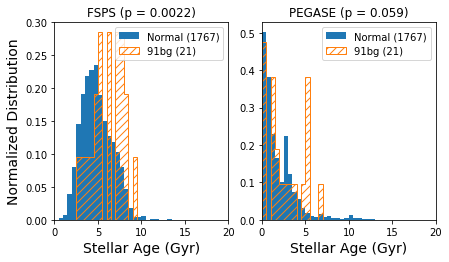

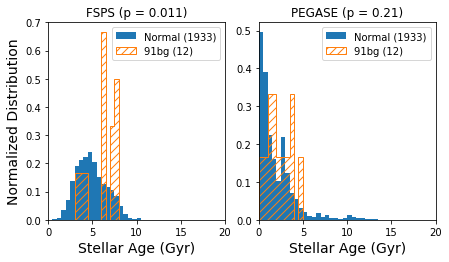

/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25


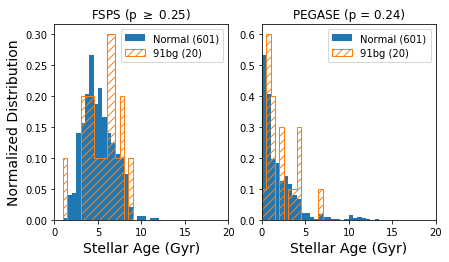

In [28]:
plot_host_age(coll_bg, coll_ia)
plt.savefig(fig_dir / 'collective_fits_age.pdf', bbox_inches='tight')
plt.show()

plot_host_age(band_bg, band_ia)
plt.savefig(fig_dir / 'band_fits_age.pdf', bbox_inches='tight')
plt.show()

plot_host_age(sifto_bg, sifto_ia)
plt.savefig(fig_dir / 'sifto_fits_age.pdf', bbox_inches='tight')
plt.show()



In [29]:
def plot_host_mass(bg_like, normal):
    """Plot FSPS and PEGASE distributions of host mass
    
    Args:
        bg_like (Series): Object Ids of 91bg like SN
        normal  (Series): Object Ids of normal SN
    """
        
    fig, axes = plot_host_property_distribution(
        'logmass', bg_like, normal, fsps_params, pegase_params, 
        bins=np.arange(7.5, 12.5, .25)) 

    axes[0].set_ylabel('Normalized Distribution', fontsize=14)
    axes[0].set_title('FSPS ' + axes[0].get_title())

    axes[1].set_title('PEGASE ' + axes[1].get_title())

    for axis in axes:
        axis.set_xlabel(r'$\log($M / M$_\odot)$', fontsize=14)
        axis.legend(loc='upper left')


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25


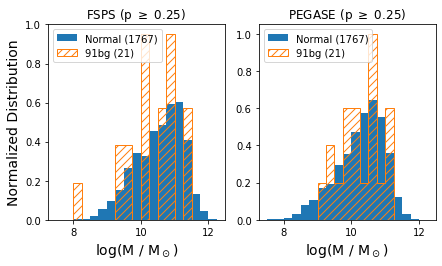

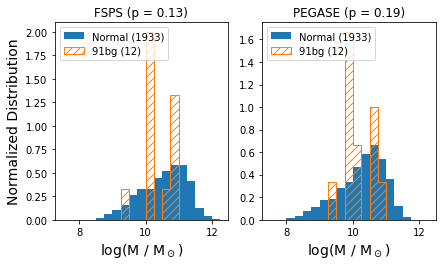

/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25


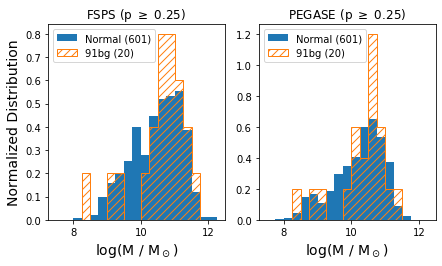

In [30]:
plot_host_mass(coll_bg, coll_ia)
plt.savefig(fig_dir / 'collective_fits_mass.pdf', bbox_inches='tight')
plt.show()

plot_host_mass(band_bg, band_ia)
plt.savefig(fig_dir / 'band_fits_mass.pdf', bbox_inches='tight')
plt.show()

plot_host_mass(sifto_bg, sifto_ia)
plt.savefig(fig_dir / 'sifto_fits_mass.pdf', bbox_inches='tight')
plt.show()


In [31]:
def plot_host_ssfr(bg_like, normal):
    """Plot FSPS and PEGASE distributions of host SSFR
    
    Args:
        bg_like (Series): Object Ids of 91bg like SN
        normal  (Series): Object Ids of normal SN
    """
    
    pegase_ssfr = pegase_params[pegase_params.logssfr > -98]
    fsps_ssfr = fsps_params.copy()
    # fsps_ssfr['logssfr'] /= 9

    fig, axes = plot_host_property_distribution(
        'logssfr', bg_like, normal, fsps_ssfr, pegase_ssfr, 
        bins=30) 

    axes[0].set_ylabel('Normalized Distribution', fontsize=14)
    axes[0].set_title('FSPS ' + axes[0].get_title())
    axes[1].set_ylim(0, 2.5)
    axes[0].set_xlim(-30, 0)
    axes[1].set_title('PEGASE ' + axes[1].get_title())

    for axis in axes:
        axis.set_xlabel('sSFR (yr$^{-1}$)', fontsize=14)

    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')
    

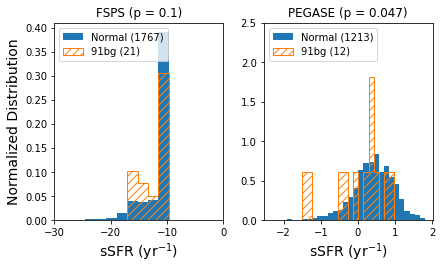

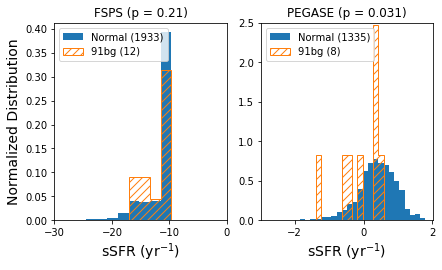

/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25


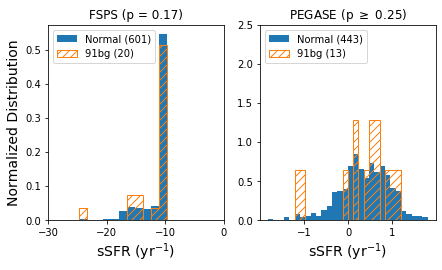

In [32]:
plot_host_ssfr(coll_bg, coll_ia)
plt.savefig(fig_dir / 'collective_fits_ssfr.pdf', bbox_inches='tight')
plt.show()

plot_host_ssfr(band_bg, band_ia)
plt.savefig(fig_dir / 'band_fits_ssfr.pdf', bbox_inches='tight')
plt.show()

plot_host_ssfr(sifto_bg, sifto_ia)
plt.savefig(fig_dir / 'sifto_fits_ssfr.pdf', bbox_inches='tight')
plt.show()


In [33]:
def plot_host_distance(bg_like, normal):
    """Plot distribution of sn distances to host center
    
    Args:
        bg_like (Series): Object Ids of 91bg like SN
        normal  (Series): Object Ids of normal SN
    """
    
    fig, axes = plot_host_property_distribution(
        'kpc', bg_like, normal, host_photometry, bins=np.arange(0, 500, 20)) 

    #fig.set_size_inches(3, 3)
    axes[0].set_xlabel('Distance to Host Center (kpc)', fontsize=14)
    axes[0].set_ylabel('Normalized Distribution', fontsize=14)
    axes[0].xaxis.set_major_locator(MultipleLocator(40))
    axes[0].xaxis.set_minor_locator(MultipleLocator(20))
    axes[0].set_xlim(0, 240)


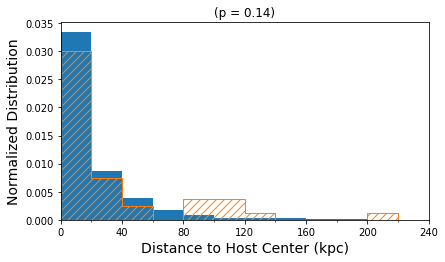

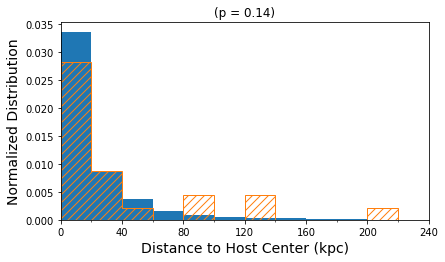

/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25


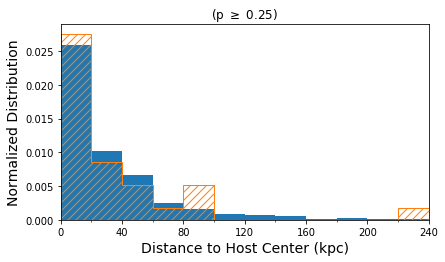

In [34]:
plot_host_distance(coll_bg, coll_ia)
plt.savefig(fig_dir / 'collective_fits_dist.pdf', bbox_inches='tight')
plt.show()

plot_host_distance(band_bg, band_ia)
plt.savefig(fig_dir / 'band_fits_dist.pdf', bbox_inches='tight')
plt.show()

plot_host_distance(sifto_bg, sifto_ia)
plt.savefig(fig_dir / 'sifto_fits_dist.pdf', bbox_inches='tight')
plt.show()


In [35]:
def plot_pvalue(
        class_df, data, max_x=3, max_y=3, x_cutoff=0, y_cutoff=0, size=30, 
        vmin=None, vmax=None, cmap='Blues'):
    """Plot the p-value for host galaxy data as a function of cutoff value
    
    Args:
        class_df (DataFrame): Classification coordinates
        data        (Series): Host galaxy
        max_x        (float): Maximum for x-axis range
        max_y        (float): Maximum for y-axis range
        x_cutoff     (float): x classification boundary
        y_cutoff     (float): y classification boundary
        size         (float): Number of values to sample in x and y direction
        vmin         (float): Min value of color map
        vmax         (float): Max value of color map
        cmap           (str): Name of color map to use
        
    Returns:
        - A matplotlib figure
        - A matplotlib axes for the main axis
        - A matplotlib axis for the color bar
    """

    sig_arr = np.zeros((size, size))
    x_arr = np.linspace(0, max_x, sig_arr.shape[0])
    y_arr = np.linspace(0, max_y, sig_arr.shape[1])

    dx = (x_arr[1] - x_arr[0]) / 2
    dy = (y_arr[1] - y_arr[0]) / 2
    extent = [x_arr[0] - dx, x_arr[-1] + dx, y_arr[0] - dy, y_arr[-1] + dy]

    for i, xcut in enumerate(x_arr):
        for j, ycut in enumerate(y_arr):
            test_bg = class_df[(class_df.x > xcut) & (class_df.y > ycut)].index
            test_normal = class_df[(class_df.x < xcut) & (class_df.y < ycut)].index
            test_bg_data = data.reindex(test_bg).dropna()
            test_normal_data = data.reindex(test_normal).dropna()
            sig = stats.anderson_ksamp([test_normal_data, test_bg_data]).significance_level
            sig_arr[i, j] = sig

    fig, axis = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4, 4))
    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = axis.imshow(sig_arr, extent=extent, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(im, cax=cax, orientation='vertical')

    axis.set_xlabel('x Cutoff', fontsize=14)
    axis.set_ylabel('y Cutoff', fontsize=14)
    axis.set_xlim(0, max_x)
    axis.set_ylim(0, max_y)
    axis.set_xticks(np.arange(0, max_x + .1, .5))
    axis.set_yticks(np.arange(0, max_y + .1, .5))

    axis.axvline(x_cutoff, linestyle='--', alpha=.8, color='red')
    axis.axhline(y_cutoff, linestyle='--', alpha=.8, color='red')

    cax.set_ylabel(r'$p$-value', fontsize=14, rotation=270, labelpad=20)

    return axis


Results for Collective fitting


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: p-value capped: true value larger than 0.25


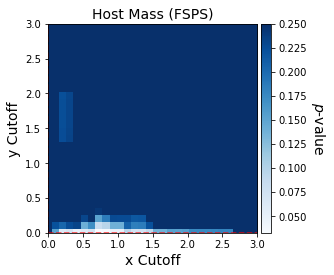

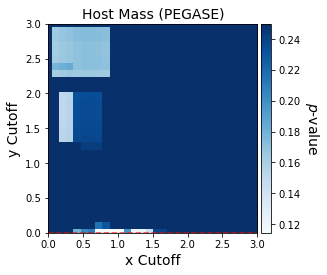

Results for Band fitting


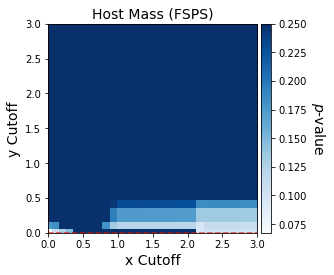

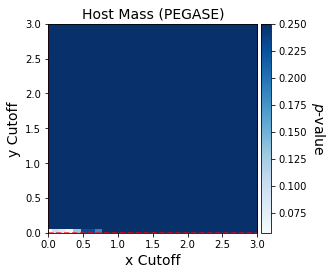

Results for SiFTO fitting


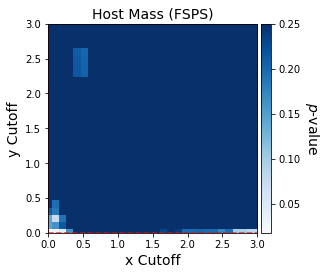

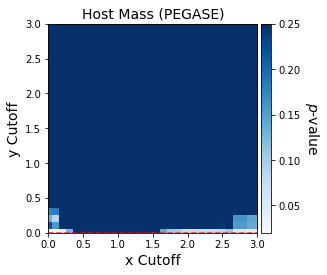

In [36]:
def plot_data():
    return zip(
        ('Collective', 'Band', 'SiFTO'),
        (coll_class, band_class, sifto_class)
    )


for fitting_method, class_coords in plot_data():
    print('Results for', fitting_method, 'fitting')

    plot_pvalue(class_coords, fsps_params.logmass).set_title('Host Mass (FSPS)', fontsize=14)
    plt.show()

    plot_pvalue(class_coords, pegase_params.logmass).set_title('Host Mass (PEGASE)', fontsize=14)
    plt.show()


Results for Collective fitting


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: p-value floored: true value smaller than 0.001


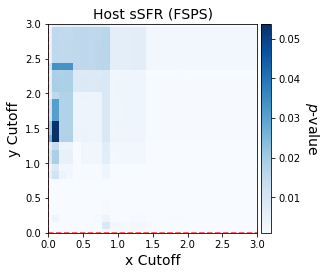

/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: p-value capped: true value larger than 0.25


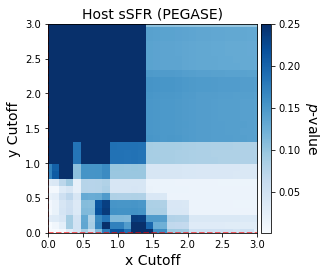

Results for Band fitting


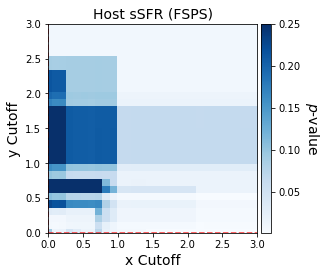

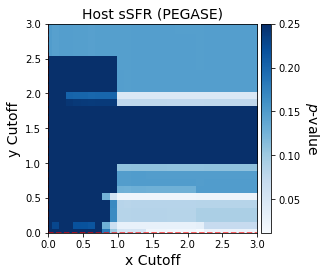

Results for SiFTO fitting


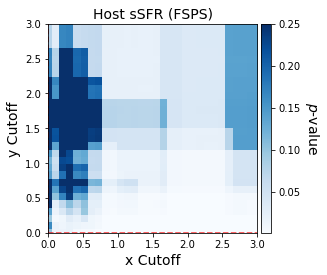

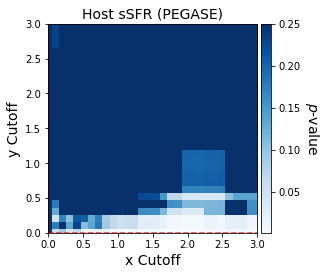

In [37]:
for fitting_method, class_coords in plot_data():
    print('Results for', fitting_method, 'fitting')
    
    plot_pvalue(class_coords, fsps_params.age).set_title('Host sSFR (FSPS)', fontsize=14)
    plt.show()

    plot_pvalue(class_coords, pegase_params.age).set_title('Host sSFR (PEGASE)', fontsize=14)
    plt.show()


Results for Collective fitting


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: p-value capped: true value larger than 0.25


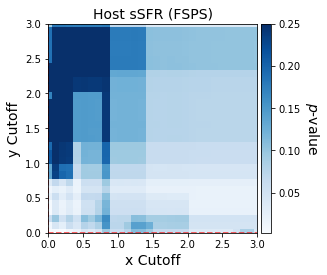

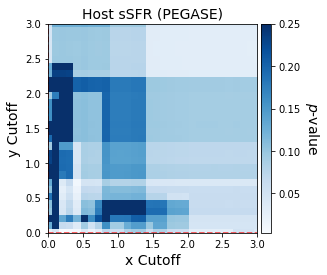

Results for Band fitting


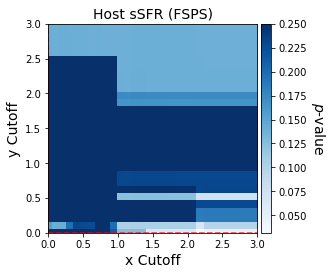

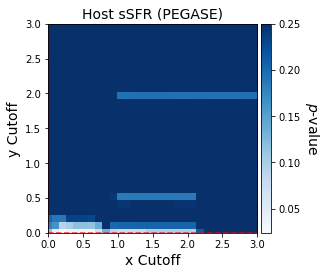

Results for SiFTO fitting


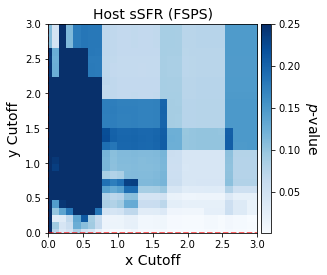

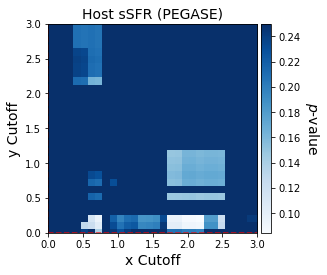

In [38]:
for fitting_method, class_coords in plot_data():
    print('Results for', fitting_method, 'fitting')
    
    plot_pvalue(class_coords, fsps_params.logssfr).set_title('Host sSFR (FSPS)', fontsize=14)
    plt.show()

    plot_pvalue(class_coords, pegase_params.logssfr).set_title('Host sSFR (PEGASE)', fontsize=14)
    plt.show()


Results for Collective fitting


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: p-value floored: true value smaller than 0.001


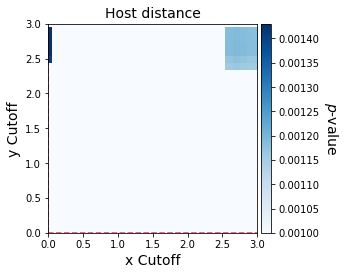

Results for Band fitting


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: p-value capped: true value larger than 0.25


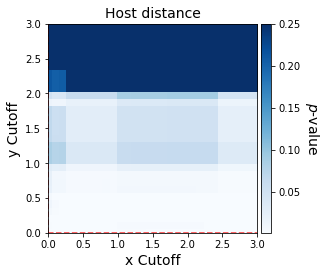

Results for SiFTO fitting


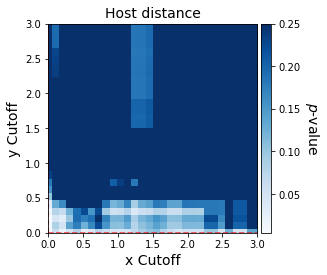

In [39]:
for fitting_method, class_coords in plot_data():
    print('Results for', fitting_method, 'fitting')
    plot_pvalue(class_coords, host_photometry.dist).set_title('Host distance', fontsize=14)
    plt.show()


In [40]:
def plot_num_points(class_df, max_x=3, max_y=3, x_cutoff=0, y_cutoff=0, size=30):
    """Plot the number of 91bgs as a function of the x and y cutoffs
    
    Args:
        class_df (DataFrame): Classification coordinates
        max_x        (float): Maximum for x-axis range
        max_y        (float): Maximum for y-axis range
        x_cutoff     (float): x classification boundary
        y_cutoff     (float): y classification boundary
        size         (float): Number of values to sample in x and y direction
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """

    count_arr = np.zeros((size, size))
    x_arr = np.linspace(0, max_x, count_arr.shape[0])
    y_arr = np.linspace(0, max_y, count_arr.shape[1])

    dx = (x_arr[1] - x_arr[0]) / 2
    dy = (y_arr[1] - y_arr[0]) / 2
    extent = [x_arr[0] - dx, x_arr[-1] + dx, y_arr[0] - dy, y_arr[-1] + dy]

    for i, xcut in enumerate(x_arr):
        for j, ycut in enumerate(y_arr):
            test_bg = class_df[(class_df.x > xcut) & (class_df.y > ycut)].index
            # test_bg_data = data.reindex(test_bg).dropna()
            count_arr[i, j] = len(test_bg)

    # fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(7 / 2, 7))
    # for axis, plot_data in zip(axes, (count_arr, sig_arr)):
    fig, axis = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(7 / 2, 7))

    divider = make_axes_locatable(axis)
    cax = divider.append_axes('right', size='5%', pad=0.05)

    im = axis.imshow(count_arr, extent=extent, origin='lower', cmap='Blues', vmin=0, vmax=50)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axis.axvline(x_cutoff, linestyle='--', alpha=.8, color='red')
    axis.axhline(y_cutoff, linestyle='--', alpha=.8, color='red')

    axis.set_ylabel('y Cutoff', fontsize=10)
    axis.set_xlabel('x Cutoff', fontsize=10)
    axis.set_title('Number of 91bg points', fontsize=10)
    axis.contour(x_arr, y_arr, count_arr, levels=np.arange(0, 51, 10), colors='k')
    axis.contour(x_arr, y_arr, count_arr, levels=np.arange(5, 26, 5), colors='k', linestyles=':')
    axis.set_xlim(0, max_x)
    axis.set_ylim(0, max_y)
    axis.set_xticks(np.arange(0, max_x + .1, .5))
    axis.set_yticks(np.arange(0, max_y + .1, .5))

    cax.set_yticks(np.arange(0, 51, 10))
    cax.set_yticklabels(['0', '10', '20', '30', '40', r'$\geq$50'])
    cax.set_ylabel(r'Number of Points', fontsize=10, rotation=270, labelpad=12)

    return fig, axis


/opt/anaconda3/envs/Photometric-Classification/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Use the colorbar set_ticks() method instead.


(<Figure size 252x504 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x146f85410>)

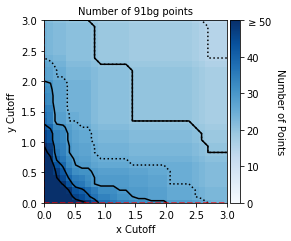

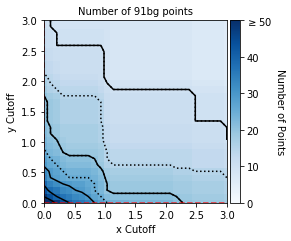

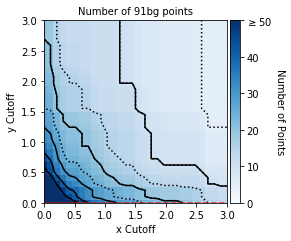

In [41]:
plot_num_points(coll_class)
plot_num_points(band_class)
plot_num_points(sifto_class)
